In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from tqdm import tqdm

df = pd.read_csv('/Users/jasonwang/Library/CloudStorage/OneDrive-UniversityofVirginia/Coding/tennis/data/full/final.csv')


: 

In [ ]:
# Remove rows with NaN or empty values in 'joint_angles_100'
df_clean = df[df['joint_angles_100'].notna() & (df['joint_angles_100'] != '')].copy()
y = df_clean['Speed_MPH']
# Convert the 'joint_angles_100' column to a numpy array of shape (n, 800, 1)
x = np.stack(df_clean['joint_angles_100'].apply(lambda s: np.array(ast.literal_eval(s)).flatten()).values)
print(x.shape)  # Should print (n, 800)

(6292, 800)


  5%|▌         | 1/20 [00:06<02:00,  6.36s/it]

Epoch 1/20 - Train Loss: 1.1843 - Val Loss: 0.9654


 10%|█         | 2/20 [00:08<01:10,  3.93s/it]

Epoch 2/20 - Train Loss: 0.9648 - Val Loss: 0.9540


 15%|█▌        | 3/20 [00:10<00:53,  3.12s/it]

Epoch 3/20 - Train Loss: 0.9307 - Val Loss: 0.9455


 20%|██        | 4/20 [00:12<00:43,  2.72s/it]

Epoch 4/20 - Train Loss: 0.9419 - Val Loss: 0.9424


 25%|██▌       | 5/20 [00:14<00:37,  2.50s/it]

Epoch 5/20 - Train Loss: 0.9229 - Val Loss: 0.9507


 30%|███       | 6/20 [00:17<00:33,  2.37s/it]

Epoch 6/20 - Train Loss: 0.9165 - Val Loss: 0.9147


 35%|███▌      | 7/20 [00:19<00:29,  2.28s/it]

Epoch 7/20 - Train Loss: 0.9020 - Val Loss: 0.9194


 40%|████      | 8/20 [00:21<00:26,  2.22s/it]

Epoch 8/20 - Train Loss: 0.8784 - Val Loss: 0.9197


 45%|████▌     | 9/20 [00:23<00:24,  2.22s/it]

Epoch 9/20 - Train Loss: 0.8715 - Val Loss: 0.8861


 50%|█████     | 10/20 [00:25<00:21,  2.19s/it]

Epoch 10/20 - Train Loss: 0.8731 - Val Loss: 0.8906


 55%|█████▌    | 11/20 [00:27<00:19,  2.17s/it]

Epoch 11/20 - Train Loss: 0.8562 - Val Loss: 0.8947


 60%|██████    | 12/20 [00:29<00:17,  2.17s/it]

Epoch 12/20 - Train Loss: 0.8419 - Val Loss: 0.8994


 65%|██████▌   | 13/20 [00:32<00:15,  2.16s/it]

Epoch 13/20 - Train Loss: 0.8344 - Val Loss: 0.8846


 70%|███████   | 14/20 [00:34<00:12,  2.16s/it]

Epoch 14/20 - Train Loss: 0.8278 - Val Loss: 0.8870


 75%|███████▌  | 15/20 [00:36<00:10,  2.15s/it]

Epoch 15/20 - Train Loss: 0.8150 - Val Loss: 0.8936


 80%|████████  | 16/20 [00:38<00:08,  2.18s/it]

Epoch 16/20 - Train Loss: 0.8133 - Val Loss: 0.8946


 85%|████████▌ | 17/20 [00:40<00:06,  2.17s/it]

Epoch 17/20 - Train Loss: 0.8090 - Val Loss: 0.8867


 90%|█████████ | 18/20 [00:42<00:04,  2.16s/it]

Epoch 18/20 - Train Loss: 0.8016 - Val Loss: 0.8862


 95%|█████████▌| 19/20 [00:45<00:02,  2.16s/it]

Epoch 19/20 - Train Loss: 0.7956 - Val Loss: 0.8957


100%|██████████| 20/20 [00:47<00:00,  2.36s/it]

Epoch 20/20 - Train Loss: 0.7779 - Val Loss: 0.8651


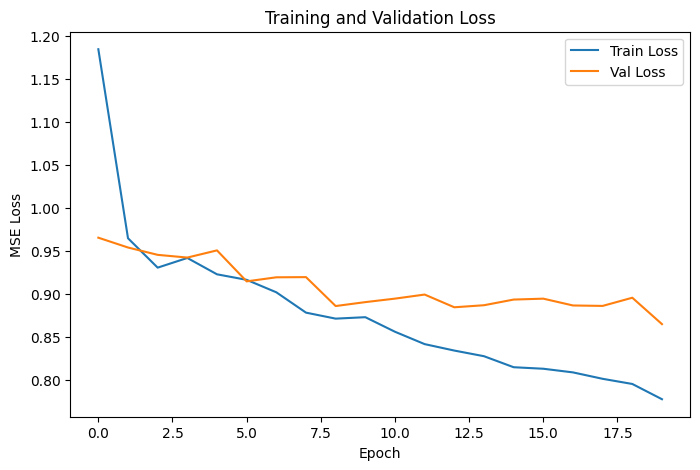

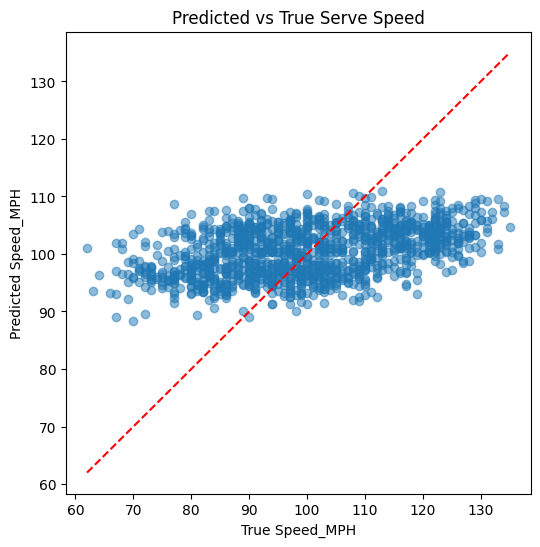

In [24]:
# Addressing overfitting:
# - Add more dropout
# - Add batch normalization
# - Reduce model size
# - Consider L2 regularization (weight decay in optimizer, set later)
# - Optionally, early stopping (handled outside model)
device = torch.device("cuda" if torch.cuda.is_available() else "mps")

class CNN1DSpeedPredictor(nn.Module):
    def __init__(self):
        super(CNN1DSpeedPredictor, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, padding=2),  # Fewer filters
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),  # 800 -> 400
            nn.Dropout(0.2),

            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),  # 400 -> 200  
            nn.Dropout(0.2),

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),  # 200 -> 100
            nn.Dropout(0.2),
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 100, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        # x shape: (batch_size, 1, 800)
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Prepare data for PyTorch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Standardize X and y
scaler_x = StandardScaler()
x_scaled = scaler_x.fit_transform(x)
x_scaled = x_scaled.reshape(-1, 1, 800)  # (n_samples, 1, 800)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(
    x_scaled, y_scaled, test_size=0.2, random_state=42
)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

# DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Instantiate model, loss, optimizer
model = CNN1DSpeedPredictor().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
n_epochs = 20
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * xb.size(0)
    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}")

# Plot training and validation loss
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluate on validation set (inverse transform to original scale)
model.eval()
with torch.no_grad():
    preds_val = []
    for xb, _ in val_loader:
        xb = xb.to(device)
        preds = model(xb).cpu().numpy()
        preds_val.append(preds)
    preds_val = np.concatenate(preds_val).flatten()
    preds_val_orig = scaler_y.inverse_transform(preds_val.reshape(-1,1)).flatten()
    y_val_orig = scaler_y.inverse_transform(y_val.reshape(-1,1)).flatten()

# Scatter plot of predictions vs true values
plt.figure(figsize=(6,6))
plt.scatter(y_val_orig, preds_val_orig, alpha=0.5)
plt.xlabel('True Speed_MPH')
plt.ylabel('Predicted Speed_MPH')
plt.title('Predicted vs True Serve Speed')
plt.plot([y_val_orig.min(), y_val_orig.max()], [y_val_orig.min(), y_val_orig.max()], 'r--')
plt.show()



Correlation between true and predicted serve speed: r = 0.421 (p = 2.63e-55)


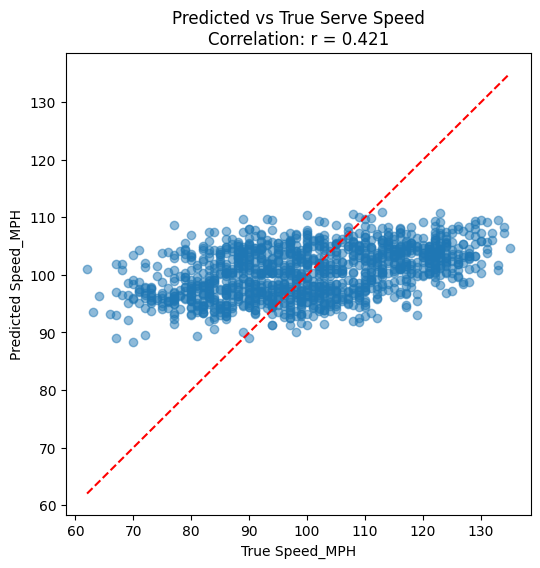

In [25]:
# Calculate and print the correlation between true and predicted values
from scipy.stats import pearsonr

corr, pval = pearsonr(y_val_orig, preds_val_orig)
print(f"Correlation between true and predicted serve speed: r = {corr:.3f} (p = {pval:.3g})")

# Scatter plot of predictions vs true values
plt.figure(figsize=(6,6))
plt.scatter(y_val_orig, preds_val_orig, alpha=0.5)
plt.xlabel('True Speed_MPH')
plt.ylabel('Predicted Speed_MPH')
plt.title(f'Predicted vs True Serve Speed\nCorrelation: r = {corr:.3f}')
plt.plot([y_val_orig.min(), y_val_orig.max()], [y_val_orig.min(), y_val_orig.max()], 'r--')
plt.show()